In [22]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from tqdm import tqdm
import random
import numpy as np

import matplotlib.patches as mpatches
from typing import List, Optional, Tuple

from src.data.bvisa_dm import CS_Dataset
import SimpleITK as sitk

sitk.ProcessObject_SetGlobalWarningDisplay(False)


In [23]:
ds_via11 = CS_Dataset('via11', 'train', 'mp2rage_raw',
                'bvisa_CS', dataset_path='',
                preload=False)

In [24]:
ds_bvisa = CS_Dataset('bvisa', 'train', 'skull_stripped', 'central_sulcus',
                 '/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa', False)

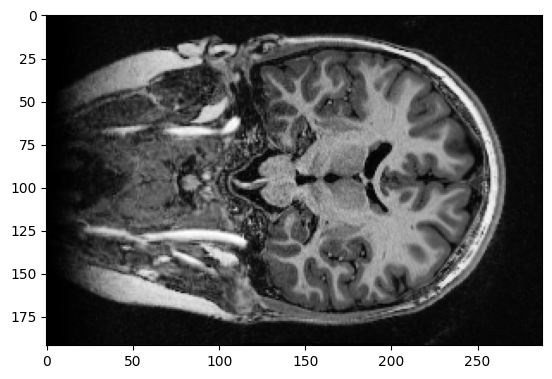

In [48]:
a = sitk.ReadImage(str(ds_via11.img_paths[0][0]))
# a = sitk.DICOMOrient(a, 'RAS')
# a = sitk.DICOMOrient(a, 'PSR')
plt.imshow(sitk.GetArrayFromImage(a)[:, :, 150], cmap='gray')

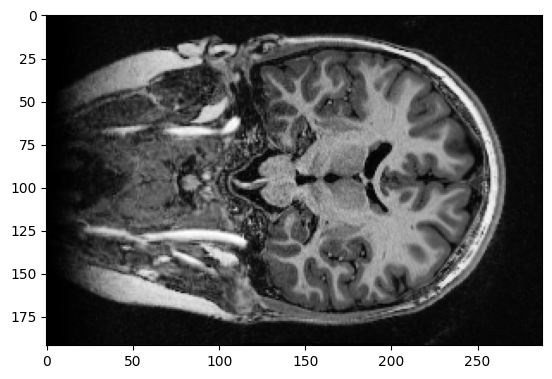

In [47]:
plt.imshow(sitk.GetArrayFromImage(a)[:, :, 150], cmap='gray')

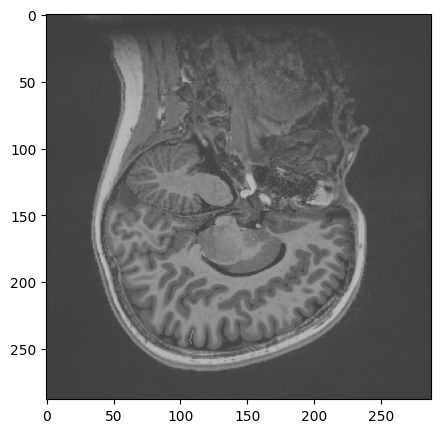

In [20]:
samplevia11 = ds_via11[0]
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 110
axs.imshow(samplevia11['target'][:, :, s], alpha=0.5, cmap='gray')
axs.imshow(samplevia11['image'][0, :, :, s], cmap='gray', alpha=0.5)
plt.show()

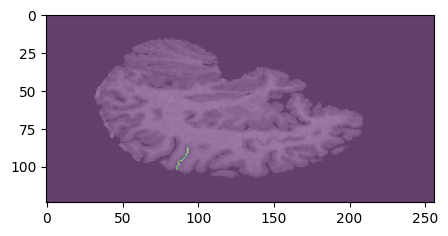

In [21]:
samplebvisa = ds_bvisa[0]
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 90
axs.imshow(samplebvisa['image'][0, :, :, s], cmap='gray', alpha=0.5)
axs.imshow(samplebvisa['target'][:, :, s], alpha=0.5)
plt.show()

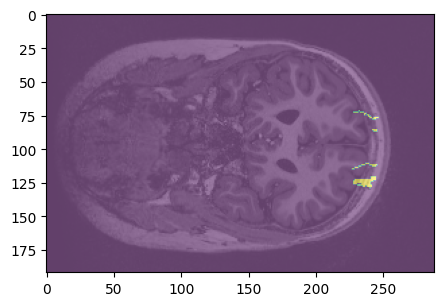

In [58]:
img = sitk.ReadImage(str(ds_via11.img_paths[0][0]))
pred = sitk.ReadImage('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/CS1x_synthsegSST_tverskyLoss_monaBasicUnet-freezeEncoder/sub-via010.nii.gz')
img = sitk.GetArrayFromImage(img)

pred = sitk.GetArrayFromImage(pred)
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 110
axs.imshow(img[:, :, s], alpha=0.5, cmap='gray')
axs.imshow(pred[:, :, s], alpha=0.5)
plt.show()

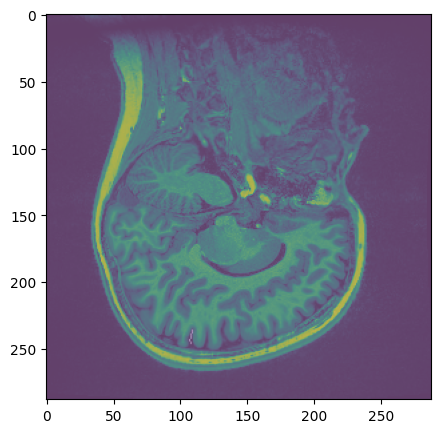

In [51]:
samplevia11 = ds_via11[0]
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 110
axs.imshow(samplevia11['target'][:, :, s], alpha=0.5, cmap='gray')
axs.imshow(samplevia11['image'][0, :, :, s], alpha=0.5)
plt.show()